In [435]:
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import pandas as pd
import numpy as np

import nltk
import spacy

import re

import gensim
from gensim import corpora, models, similarities


In [7]:
df = pd.read_csv("data/Emails.csv")
df = df[['Id','ExtractedBodyText']].dropna() # Remove all the null values

In [8]:
df.head(5)

,Id,ExtractedBodyText
1,2,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,3,Thx
4,5,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,6,Pis print.\n-•-...-^\nH < hrod17@clintonernail...
7,8,"H <hrod17@clintonemail.corn>\nFriday, March 11..."


# Building a Text Pre-processing Pipeline

In [10]:
def clean_email_text(text):
    text = text.replace('\n'," ") # Take out the paragraph space
    text = re.sub(r"-", " ", text) # Split the words with "-" (for example：pre-processing ==> pre processing）
    text = re.sub(r"\d+/\d+/\d+", "", text) # Take out the dates
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text) # Take out the time
    text = re.sub(r"[\w]+@[\.\w]+", "", text) # Take out the emails
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) # Take out the websites
    pure_text = ''
    # Validate to check if there are any non-text content 
    for letter in text:
        # Keep only letters and spaces
        if letter.isalpha() or letter==' ':
            pure_text += letter
    # Join the words are not stand-alone letters
    text = ' '.join(word for word in pure_text.split() if len(word)>1)
    return text

In [11]:
docs = df['ExtractedBodyText']
docs = docs.apply(lambda x: clean_email_text(x))

In [223]:
docs.head(3).values

array(['Thursday March PM Latest How Syria is aiding Qaddafi and more Sid hrc memo syria aiding libya docx hrc memo syria aiding libya docx March For Hillary',
       'Thx',
       'Friday March PM Huma Abedin Fw Latest How Syria is aiding Qaddafi and more Sid hrc memo syria aiding libya docx Pis print'],
      dtype=object)

In [14]:
docs.values

array(['Thursday March PM Latest How Syria is aiding Qaddafi and more Sid hrc memo syria aiding libya docx hrc memo syria aiding libya docx March For Hillary',
       'Thx',
       'Friday March PM Huma Abedin Fw Latest How Syria is aiding Qaddafi and more Sid hrc memo syria aiding libya docx Pis print',
       ...,
       'Big change of plans in the Senate Senator Reid just announced that he was no longer going to move forward with the omnibus appropriations bill Instead he filed cloture motions on the repeal of Dont Ask Dont Tell and the DREAM Act Those petitions will ripen on Saturday So it looks like the Senate will be again considering the new START Treaty tomorrow We should know the starting time shortly',
       'PVerveer Friday December AM From Please let me know if can be of any help to your department and will happy to do and please thank Mrs Hillary Clinton on behalf of me and supporting Afghan women Thank you',
       'See below'], dtype=object)

In [224]:
docs.shape

(6742,)

In [225]:
docs

1       Thursday March PM Latest How Syria is aiding Q...
2                                                     Thx
4       Friday March PM Huma Abedin Fw Latest How Syri...
5       Pis print Wednesday September PM Fw Meet The R...
7       Friday March PM Huma Abedin Fw Latest How Syri...
                              ...                        
7938    Hi Sorry havent had chance to see you but did ...
7939    assume you saw this by now if not its worth re...
7941    Big change of plans in the Senate Senator Reid...
7943    PVerveer Friday December AM From Please let me...
7944                                            See below
Name: ExtractedBodyText, Length: 6742, dtype: object

# spaCy - Lemmatize

In [278]:
import spacy
import re
import string
# Create our list of punctuation marks
punctuations = string.punctuation
# Load English tokenizer, tagger, parser, NER and word vectors
parser = spacy.load('en_core_web_sm')
# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return ' '.join(mytokens)

In [228]:
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [227]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [272]:
def lemma_nltk(text):
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [279]:
docs_lemma = docs.apply(lambda x: spacy_tokenizer(x))

In [280]:
docs_lemma 

1       thursday march pm latest syria aid qaddafi sid...
2                                                     thx
4       friday march pm huma abedin fw latest syria ai...
5       pis print wednesday september pm fw meet right...
7       friday march pm huma abedin fw latest syria ai...
                              ...                        
7938    hi sorry chance want hear directly great resul...
7939                  assume worth read forwarded message
7941    big change plan senate senator reid announce l...
7943    pverveer friday december let know help departm...
7944                                                     
Name: ExtractedBodyText, Length: 6742, dtype: object

# TF-IDF with stop words

In [530]:
stoplist = ['very', 'ourselves', 'am', 'doesn', 'through', 'me', 'against', 'up', 'just', 'her', 'ours', 
            'couldn', 'because', 'is', 'isn', 'it', 'only', 'in', 'such', 'too', 'mustn', 'under', 'their', 
            'if', 'to', 'my', 'himself', 'after', 'why', 'while', 'can', 'each', 'itself', 'his', 'all', 'once', 
            'herself', 'more', 'our', 'they', 'hasn', 'on', 'ma', 'them', 'its', 'where', 'did', 'll', 'you', 
            'didn', 'nor', 'as', 'now', 'before', 'those', 'yours', 'from', 'who', 'was', 'm', 'been', 'will', 
            'into', 'same', 'how', 'some', 'of', 'out', 'with', 's', 'being', 't', 'mightn', 'she', 'again', 'be', 
            'by', 'shan', 'have', 'yourselves', 'needn', 'and', 'are', 'o', 'these', 'further', 'most', 'yourself', 
            'having', 'aren', 'here', 'he', 'were', 'but', 'this', 'myself', 'own', 'we', 'so', 'i', 'does', 'both', 
            'when', 'between', 'd', 'had', 'the', 'y', 'has', 'down', 'off', 'than', 'haven', 'whom', 'wouldn', 
            'should', 've', 'over', 'themselves', 'few', 'then', 'hadn', 'what', 'until', 'won', 'no', 'about', 
            'any', 'that', 'for', 'shouldn', 'don', 'do', 'there', 'doing', 'an', 'or', 'ain', 'hers', 'wasn', 
            'weren', 'above', 'a', 'at', 'your', 'theirs', 'below', 'other', 'not', 're', 'him', 'during', 'which', 
            'docx','fyi','fw','get','see','ok','pm','whose','would','pls','thx','yes','print','okay']

In [531]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=0.0015, stop_words=stoplist)
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_lemma)

In [532]:
len(list(pd.DataFrame(dtm_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names()).head().columns))

3039

In [533]:
list(pd.DataFrame(dtm_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names()).head().columns)

['abandon',
 'abbas',
 'abc',
 'abedin',
 'ability',
 'able',
 'abraham',
 'abroad',
 'absence',
 'absent',
 'absolutely',
 'abu',
 'abuse',
 'academic',
 'academy',
 'accept',
 'access',
 'accompany',
 'accomplish',
 'accomplishment',
 'accord',
 'accordingly',
 'account',
 'accountability',
 'accountable',
 'accusation',
 'accuse',
 'achieve',
 'achievement',
 'acknowledge',
 'act',
 'action',
 'active',
 'actively',
 'activist',
 'activity',
 'actor',
 'actual',
 'actually',
 'ad',
 'adapt',
 'add',
 'addition',
 'additional',
 'address',
 'adjust',
 'administration',
 'administrator',
 'admire',
 'admit',
 'adopt',
 'adult',
 'advance',
 'advantage',
 'advice',
 'advise',
 'adviser',
 'advisor',
 'advocacy',
 'advocate',
 'af',
 'affair',
 'affairs',
 'affect',
 'affiliate',
 'afford',
 'afghan',
 'afghanistan',
 'afp',
 'afpak',
 'africa',
 'african',
 'aftermath',
 'afternoon',
 'afterward',
 'age',
 'agency',
 'agenda',
 'agent',
 'aggressive',
 'aggressively',
 'ago',
 'agree',

In [534]:
tf = pd.DataFrame(dtm_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [535]:
tf.shape

(6742, 3039)

In [304]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [514]:
lsa = TruncatedSVD(7)
doc_topic = lsa.fit_transform(tf)
lsa.explained_variance_ratio_

array([0.00675402, 0.0106944 , 0.00980212, 0.00912139, 0.00785217,
       0.00743556, 0.00706703])

In [515]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7"],
             columns = tfidf_vectorizer.get_feature_names())
topic_word

,abandon,abbas,abc,abedin,ability,able,abraham,abroad,absence,absent,...,year,yemen,yep,yesterday,york,young,youth,zelaya,zero,zone
component_1,0.003,0.006,0.001,0.098,0.005,0.016,0.002,0.003,0.001,0.001,...,0.061,0.002,0.005,0.030,0.017,0.009,0.004,0.005,0.002,0.004
component_2,-0.002,-0.004,-0.000,0.234,-0.002,-0.006,-0.002,-0.001,-0.001,-0.000,...,-0.025,-0.000,0.002,-0.005,-0.016,-0.004,-0.000,0.000,-0.001,-0.002
component_3,-0.000,0.001,0.000,0.030,-0.001,-0.007,0.003,0.001,-0.000,0.000,...,-0.015,0.000,-0.002,-0.011,0.030,-0.001,0.002,-0.003,0.000,0.001
component_4,0.000,0.001,0.000,-0.035,0.000,-0.000,-0.000,0.000,0.000,0.000,...,0.008,-0.000,0.009,0.003,-0.001,0.001,-0.000,-0.000,0.000,0.000
component_5,-0.002,0.003,-0.001,0.006,-0.001,-0.006,0.001,-0.002,-0.001,-0.001,...,-0.049,-0.000,-0.003,-0.013,0.004,-0.006,-0.002,0.005,-0.001,-0.003
component_6,-0.001,-0.001,-0.000,0.429,-0.002,-0.005,-0.001,-0.001,-0.001,-0.000,...,-0.028,-0.000,0.002,-0.001,-0.008,-0.003,-0.003,-0.000,-0.001,-0.001
component_7,0.002,0.001,0.001,-0.123,0.003,-0.001,-0.003,0.002,0.001,0.000,...,0.020,0.001,-0.000,-0.014,-0.005,0.001,0.002,0.002,0.001,0.004


In [476]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix+1)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [536]:
display_topics(lsa, tfidf_vectorizer.get_feature_names(), 10)


Topic  1
worker, talking, know, war, statement, tone, good, cheryl, times, office

Topic  2
cheryl, mills, huma, abedin, summary, relevant, jacob, ticket, friday, saudi

Topic  3
office, section, statement, root, department, en, rove, depart, arrive, meeting

Topic  4
relevant, bb, declassify, house, states, reasonable, senior, hold, agree, great

Topic  5
talking, tone, office, section, need, root, cheryl, meeting, war, en

Topic  6
huma, abedin, lona, valuable, assistant, secretarys, specific, statement, talking, lauren

Topic  7
statement, lona, valuable, talking, assistant, secretarys, specific, direct, cheryl, mills


In [517]:
doc_topic

array([[ 6.76660377e-02,  5.77997164e-02,  5.53350389e-03, ...,
        -3.92988029e-02,  1.69223331e-02, -1.30647635e-02],
       [ 3.88591729e-17,  8.67818571e-16, -2.39168815e-17, ...,
        -9.45738973e-17,  5.10901479e-16, -1.68063861e-16],
       [ 1.07630505e-01,  1.44829391e-01,  8.86854194e-03, ...,
        -4.14762069e-02,  1.75707579e-01, -1.43907456e-01],
       ...,
       [ 1.98339959e-01, -5.44896690e-02, -5.80882657e-02, ...,
        -8.47519331e-03, -2.40600308e-02, -4.95450270e-03],
       [ 2.10923337e-01, -1.02660083e-02, -3.33655488e-02, ...,
        -1.02976612e-01, -5.15713227e-02,  1.51851556e-02],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00]])

# pyLDA

In [429]:
# sklearn

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# logging (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [427]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


In [472]:
lda_tfidf = LatentDirichletAllocation(n_components=7, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=7, random_state=0)

In [473]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.003275  0.136475       1        1  31.147309
0     -0.024197  0.039124       2        1  22.312183
6     -0.123391 -0.104108       3        1  11.895601
1      0.180767 -0.118755       4        1  11.181250
5     -0.093363 -0.063400       5        1   8.835584
2     -0.061205  0.052190       6        1   7.494427
4      0.124665  0.058474       7        1   7.133646, topic_info=         Term       Freq      Total Category  logprob  loglift
2296  release  67.000000  67.000000  Default  30.0000  30.0000
450    cheryl  67.000000  67.000000  Default  29.0000  29.0000
2029      pis  47.000000  47.000000  Default  28.0000  28.0000
1736    mills  57.000000  57.000000  Default  27.0000  27.0000
3      abedin  49.000000  49.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
869     early   8.344051  31.193070   Topic7  -5.0384   1.3217
1764   monday   9.276666  52.321100   Topic7  -4.9324   0.9105
2484      set   7.931918  33.126019   Topic7  -5.0890   1.2109
1267     hear   7.095241  33.824337   Topic7  -5.2005   1.0786
1598     like   6.822036  55.480531   Topic7  -5.2398   0.5445

[415 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3         4  0.971167      abedin
3         5  0.020233      abedin
10        2  0.202121  absolutely
10        3  0.606363  absolutely
41        1  0.116927         add
...     ...       ...         ...
3030      2  0.692958        year
3030      3  0.032998        year
3030      6  0.032998        year
3032      5  0.928575         yep
3034      1  0.951904        york

[1020 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 2, 6, 3, 5])

# KMeans

In [479]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

In [482]:
def display_cluster(X, km=[], num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], c=color[0], alpha=alpha, s=s)
        
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

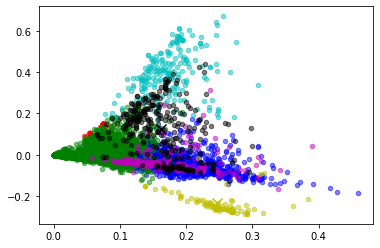

In [569]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic,km,num_clusters)

In [519]:
inertias = []

for k_ in np.arange(1, 30):
    km = KMeans(n_clusters=k_)
    km.fit(doc_topic)
    inertias.append(km.inertia_)

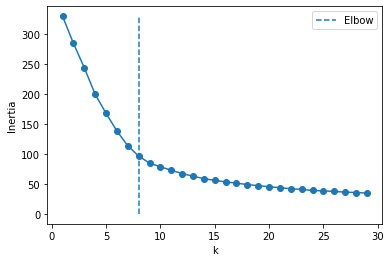

In [520]:
plt.plot(np.arange(1, 30), inertias, marker='o')
plt.vlines(x=8, ymin=0, ymax=max(inertias), ls='--', label='Elbow')
plt.ylabel("Inertia")
plt.xlabel('k')
plt.legend();

# CorEx

In [521]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
import scipy.sparse as ss

In [542]:
words = list(np.asarray(tfidf_vectorizer.get_feature_names())) 

In [561]:
topic_model = ct.Corex(n_hidden=4, words=words, seed=1)
topic_model.fit(dtm_tfidf, words=words, docs=docs_lemma) # I tried 7 topics first, but the chart below suggested four topics

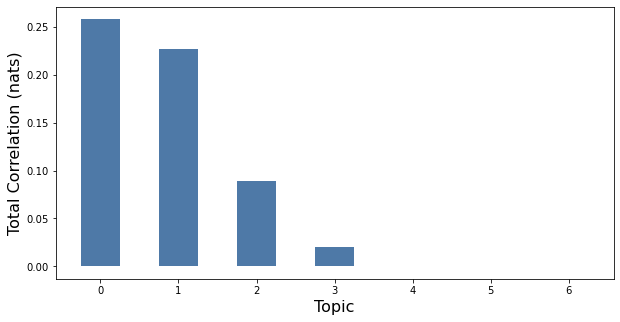

In [560]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16); 

In [562]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n+1) + ','.join(topic_words))

1: obama,president,government,states,support,united,american,mr,people,security
2: secretarys,office,en,depart,route,state,room,department,arrive,residence
3: immediate,laszczych,assistance,joanne,access,toiv,nora,operations,travel,contact
4: add,screen,sandy,ross,resume,resign,reminder,reluctant,reaction,quiet


In [565]:
topic_model.get_top_docs(topic=3, n_docs=2)

[('sullivan jacob sullivanjjstategov thursday march pm mills cheryl rch',
  -0.09319450706817481),
 ('slaughter anne marie slaughterastategov friday june pm sullivan jacob mills cheryl clarification turkeybrazil',
  -0.09397537975122114)]

In [567]:
predictions = pd.DataFrame(topic_model.labels, columns=['topic'+str(i) for i in range(4)])
predictions.head(11)

,topic0,topic1,topic2,topic3
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,True,False,True
4,False,False,False,True
5,False,False,False,True
6,False,False,False,True
7,False,False,False,True
8,False,False,False,True
9,False,False,False,True


### CorEx Anchor Words

Topic  1
worker, talking, know, war, statement, tone, good, cheryl, times, office

Topic  2
cheryl, mills, huma, abedin, summary, relevant, jacob, ticket, friday, saudi

Topic  3
office, section, statement, root, department, en, rove, depart, arrive, meeting

Topic  4
relevant, bb, declassify, house, states, reasonable, senior, hold, agree, great

Topic  5
talking, tone, office, section, need, root, cheryl, meeting, war, en

Topic  6
huma, abedin, lona, valuable, assistant, secretarys, specific, statement, talking, lauren

Topic  7
statement, lona, valuable, talking, assistant, secretarys, specific, direct, cheryl, mills

In [571]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(dtm_tfidf, words=words, docs=docs_lemma, 
                anchors=[['cheryl', 'mills'], 
                         ['huma','abedin'], 
                         ['election'], 
                         ['war'],
                         ['saudi'], 
                         ['office','statement']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: mills,cheryl,jacob,sullivan,april,friday,laszczych,thursday,joanne,toiv
1: recipient,deliver,message,administrator,microsoft,huma,abedin,distribution,mail,jan
2: af,quiet,quick,posner,plant,nomination,ni,miguel,react,matt
3: obama,war,president,government,states,support,united,american,mr,people
4: amb,shannon,saudi,sat,russians,reed,recommend,ray,prefer,pitch
5: office,secretarys,en,room,depart,route,department,state,arrive,residence


In [592]:
topics

[[('mills', 0.03918934508638132),
  ('cheryl', 0.03605097946021358),
  ('jacob', 0.004984884228777077),
  ('sullivan', 0.00457495430057296),
  ('april', 0.004241468663616807),
  ('friday', 0.0036173039218076936),
  ('laszczych', 0.003405239148764674),
  ('thursday', 0.0033808030283785846),
  ('joanne', 0.003132335956414239),
  ('toiv', 0.002590762458360527)],
 [('recipient', 0.006288300718371528),
  ('deliver', 0.003053893503448967),
  ('message', 0.0027460221601577684),
  ('administrator', 0.0010459037088525944),
  ('microsoft', 0.0009557569180908629),
  ('huma', -0.0003255026628663074),
  ('abedin', -0.00029137039328959306),
  ('distribution', 0.0004180513542191419),
  ('mail', 0.0003552914898963588),
  ('jan', 0.00030273261006188675)],
 [('af', 0.0),
  ('quiet', 0.0),
  ('quick', 0.0),
  ('posner', 0.0),
  ('plant', 0.0),
  ('nomination', 0.0),
  ('ni', 0.0),
  ('miguel', 0.0),
  ('react', 0.0),
  ('matt', 0.0)],
 [('obama', 0.008620653709718219),
  ('war', 0.00337670007859896),
  (

In [578]:
#!pip install wordcloud

     |████████████████████████████████| 162 kB 862 kB/s eta 0:00:01


In [579]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [593]:

# wordcloud = WordCloud(colormap="RdYlBu").generate(topics[0][0][0])
# plt.imshow(wordcloud)
# plt.axis("off")
# fontdict = {"fontsize": 50, "fontweight": "bold"}
# plt.title("Topic: War", fontdict=fontdict)
# plt.show()